In [4]:
import pandas as pd
import numpy as np
import pycaret.classification as pc
import matplotlib.pyplot as plt

import mlflow

# Configurar MLFLOW

In [5]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
print(experiment)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

<Experiment: artifact_location='/Users/gabriel_01/Documents/Estudos/trab_eng_ml/ENG_ML/code/mlruns/1', creation_time=1713228598024, experiment_id='1', last_update_time=1713228598024, lifecycle_stage='active', name='Projeto Kobe', tags={}>


In [6]:
from sklearn.model_selection import train_test_split

data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):

    df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    #Eliminate rows with missing values
    df_dev = df_dev.dropna(subset=data_cols)
    df_dev = df_dev[data_cols].copy()

    df_dev.to_parquet('../data/processed/data_filtered.parquet')
    print(f"Dimensão do dataset: {df_dev.shape}")

    xtrain, xtest, ytrain, ytest = train_test_split(
        df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
        df_dev['shot_made_flag'],
        train_size=train_perc,
        stratify=df_dev['shot_made_flag']
    )

    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest

    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({
        'perc_test': 1-train_perc,
        'colunas-selecionadas': data_cols
    })
    
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })

Dimensão do dataset: (20285, 7)


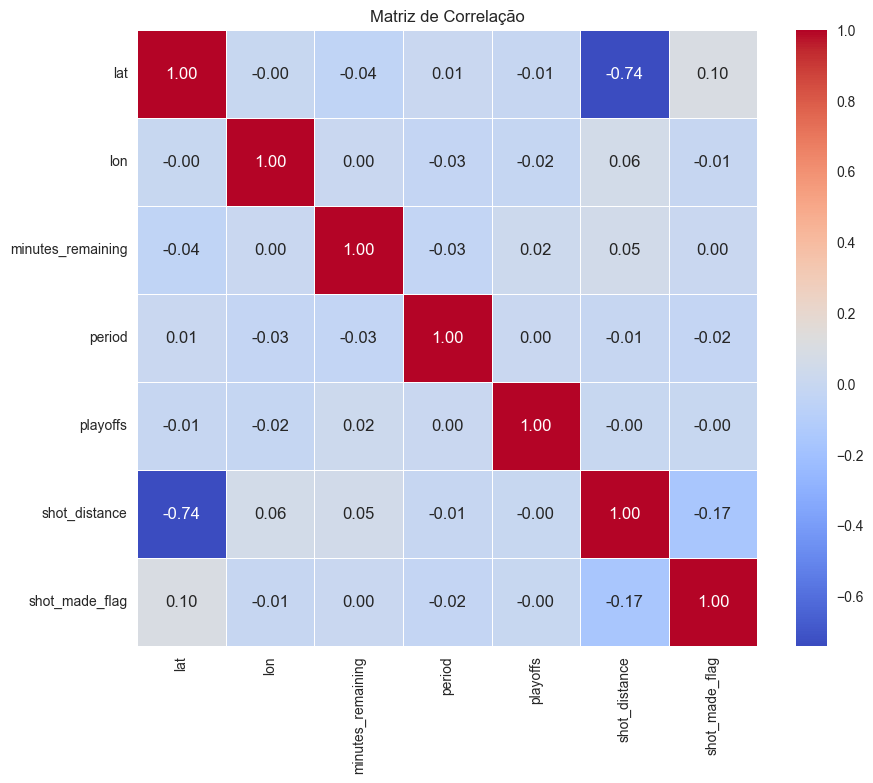

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o conjunto de dados
df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

# Selecionar as variáveis explicativas e a variável de saída
variaveis_explicativas = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
variavel_saida = 'shot_made_flag'

# Calcular a matriz de correlação
correlation_matrix = df_dev[variaveis_explicativas + [variavel_saida]].corr()

# Plotar o mapa de calor (heatmap) da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()


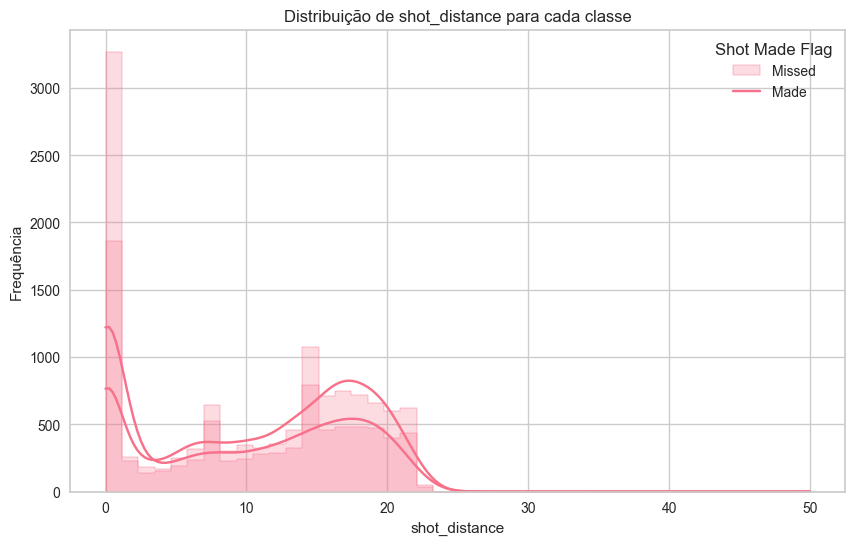

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o conjunto de dados
df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

# Variável mais relevante (por exemplo, shot_distance)
variavel_relevante = 'shot_distance'

# Plotar histograma ou gráfico de densidade para cada classe
plt.figure(figsize=(10, 6))
sns.histplot(data=df_dev, x=variavel_relevante, hue='shot_made_flag', element='step', kde=True, fill=True, palette='husl')
plt.title(f'Distribuição de {variavel_relevante} para cada classe')
plt.xlabel(variavel_relevante)
plt.ylabel('Frequência')
plt.legend(title='Shot Made Flag', labels=['Missed', 'Made'])
plt.show()


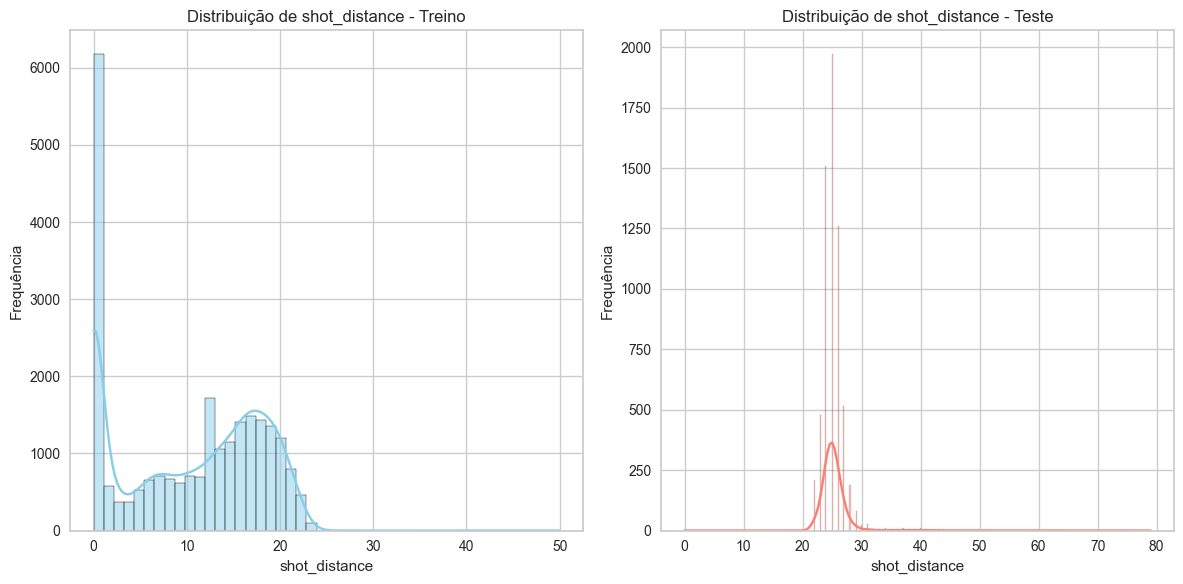

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os conjuntos de dados de treino e teste
df_treino = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
df_teste = pd.read_parquet('../data/raw/dataset_kobe_prod.parquet')

# Variável mais relevante (por exemplo, shot_distance)
variavel_relevante = 'shot_distance'

# Plotar histograma ou gráfico de densidade para cada conjunto
plt.figure(figsize=(12, 6))

# Histograma para o conjunto de treino
plt.subplot(1, 2, 1)
sns.histplot(data=df_treino, x=variavel_relevante, kde=True, color='skyblue', edgecolor='black')
plt.title(f'Distribuição de {variavel_relevante} - Treino')
plt.xlabel(variavel_relevante)
plt.ylabel('Frequência')

# Histograma para o conjunto de teste
plt.subplot(1, 2, 2)
sns.histplot(data=df_teste, x=variavel_relevante, kde=True, color='salmon', edgecolor='black')
plt.title(f'Distribuição de {variavel_relevante} - Teste')
plt.xlabel(variavel_relevante)
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


# Treinamento do modelo

In [45]:
import os
from sklearn.metrics import log_loss, f1_score
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient


registered_model_name = 'projeto_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    exp = pc.setup(
        data=xtrain,
        target='shot_made_flag',
        test_data=xtest,
        normalize=True,
    )

    list_models = exp.compare_models(['lr', 'dt'], n_select=2, sort='f1')
    list_models

    
    exp.plot_model(
        list_models[0],
        plot='vc',
        save=True,
    )
    os.rename('Validation Curve.png', 'lr_validation curve.png')
    mlflow.log_artifact('lr_validation curve.png')

    yhat_test = exp.predict_model(list_models[0])

    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test['shot_made_flag'], yhat_test.prediction_label),
    })

    yhat_test = exp.predict_model(list_models[1])

    exp.plot_model(
        list_models[1],
        plot='vc',
        save=True,
    )

    os.rename('Validation Curve.png', 'dt_validation curve.png')
    mlflow.log_artifact('dt_validation curve.png')

    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test['shot_made_flag'], yhat_test.prediction_label),
    })

    # Finalização modelo lr

    tune_model = exp.tune_model(
        list_models[0],
        optimize='f1',
        search_library='scikit-learn',
        search_algorithm='random',
        n_iter=4,
    )

    yhat_test = exp.predict_model(tune_model)

    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test.prediction_label),
    })

    final_model = exp.finalize_model(tune_model)

    # Exportacao para log e registro do modelo
    pc.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(
        xtrain[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
        model_pipe.predict(xtrain.drop('shot_made_flag', axis=1))
    )
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name= registered_model_name,
        alias = 'staging',
        version = model_version
    )

,Description,Value
0,Session id,285
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5350,0.5147,0.5873,0.5114,0.5466,0.0741,0.0748,0.0130
lr,Logistic Regression,0.5763,0.5968,0.4840,0.5659,0.5217,0.1455,0.1470,0.0110


Processing:   0%|          | 0/14 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5263,0.5953,0.5203,0.5553,0.0933,0.0941


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5842,0.6034,0.4853,0.5767,0.5271,0.1609,0.1628


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5866,0.5849,0.4238,0.5931,0.4943,0.1608,0.1673
1,0.5662,0.5663,0.4535,0.5554,0.4993,0.1235,0.1255
2,0.5872,0.5834,0.4452,0.5897,0.5074,0.1639,0.1687
3,0.5681,0.5624,0.4310,0.5623,0.4879,0.1256,0.1290
4,0.5718,0.5496,0.4155,0.5709,0.4810,0.1316,0.1365
5,0.5619,0.5761,0.4090,0.5561,0.4714,0.1120,0.1158
6,0.5662,0.5701,0.4361,0.5587,0.4899,0.1224,0.1253
7,0.5853,0.6006,0.4516,0.5853,0.5098,0.1607,0.1648
8,0.5740,0.5866,0.3837,0.5812,0.4623,0.1333,0.1412


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5263,0.5953,0.5203,0.5553,0.0933,0.0941


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'projeto_kobe' already exists. Creating a new version of this model...
Created version '4' of model 'projeto_kobe'.


In [44]:
mlflow.end_run()

In [46]:
from sklearn.metrics import roc_curve

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5263,0.5953,0.5203,0.5553,0.0933,0.0941


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5842,0.6034,0.4853,0.5767,0.5271,0.1609,0.1628


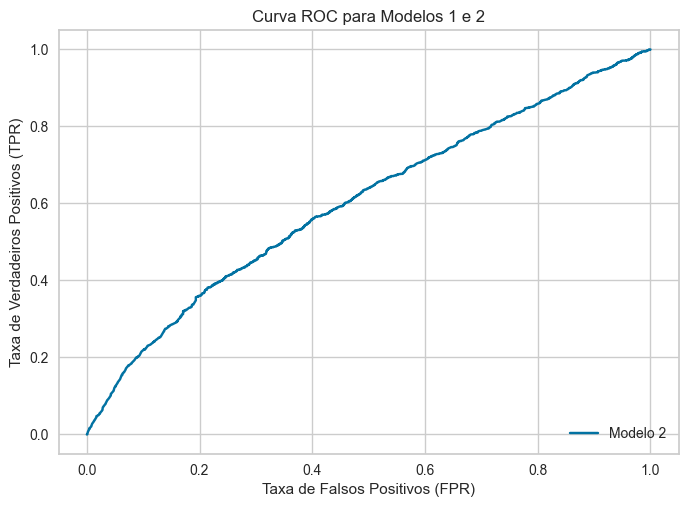

In [52]:
# do the roc curve to both models

# Primeiro Modelo
yhat_test_1 = exp.predict_model(list_models[0], raw_score=True)
fpr_1, tpr_1, thr_1 = roc_curve(yhat_test_1['shot_made_flag'], yhat_test_1.prediction_score_1)
plt.plot(fpr_1, tpr_1, label='Modelo 1')

# Segundo Modelo
yhat_test_2 = exp.predict_model(list_models[1], raw_score=True)
fpr_2, tpr_2, thr_2 = roc_curve(yhat_test_2['shot_made_flag'], yhat_test_2.prediction_score_1)
plt.plot(fpr_2, tpr_2, label='Modelo 2')

# Configuração do gráfico
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para Modelos 1 e 2')
plt.legend(loc='lower right')
plt.grid(True)

# Exibir o gráfico
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Avaliacao'):
    yhat_test = exp.predict_model(final_model)

    print(classification_report(yhat_test['shot_made_flag'], yhat_test.prediction_label))
    print(confusion_matrix(yhat_test['shot_made_flag'], yhat_test.prediction_label))

    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test.prediction_label),
    })
